In [1]:
import os
import time
import math
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import scipy.stats as st
from numpy.linalg import eig, eigh
from sklearn.metrics import roc_auc_score, mean_absolute_error, accuracy_score
from model import Specformer

In [32]:
torch.cuda.set_device(2)

def acc(labels, logits):
    labels = np.array(labels)
    logits = np.array(logits)
    index = logits.argmax(axis=1)
    return accuracy_score(labels, index)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def init_params(module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=0.01)
        if module.bias is not None:
            module.bias.data.zero_()

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def split(y, nclass):
    percls_trn = int(round(0.6 * len(y) / nclass))
    val_lb = int(round(0.2 * len(y)))

    indices = []
    for i in range(nclass):
        index = (y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0), device=index.device)]
        indices.append(index)
    
    train_index = torch.cat([i[:percls_trn] for i in indices], dim=0)  
    rest_index = torch.cat([i[percls_trn:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]
    valid_index = rest_index[:val_lb]
    test_index = rest_index[val_lb:]
    
    return train_index, valid_index, test_index

In [3]:
def run_once(seed, nclass, e, u, x, y, net, optimizer, loss, metric='loss'):

    res = []
    min_loss = 100.0
    max_acc = 0.0
    counter = 0
    
    train, valid, test = split(y, nclass)

    for idx in range(epoch):

        net.train()
        optimizer.zero_grad()
        logits, _ = net(e, u, x)
        train_loss = loss(logits[train], y[train])
        train_loss.backward()
        optimizer.step()

        net.eval()
        logits, _ = net(e, u, x)
        val_pred = logits[valid].cpu().data.numpy()
        val_label = y[valid].cpu().data.numpy()
        val_loss = loss(logits[valid], y[valid]).item()
        val_acc = acc(val_label, val_pred)

        test_pred = logits[test].cpu().data.numpy()
        test_label = y[test].cpu().data.numpy()
        test_acc = acc(test_label, test_pred)

        res.append([train_loss.item(), val_loss, val_acc, test_acc])

        if metric == 'loss':
            if val_loss < min_loss:
                min_loss = val_loss
                counter = 0
            else:
                counter += 1
        else:
            if val_acc > max_acc:
                max_acc = val_acc
                counter = 0
            else:
                counter += 1

        if counter == 200:
            break

    if metric == 'loss':
        ind = sorted(res, key=lambda x: x[1], reverse=False)
    else:
        ind = sorted(res, key=lambda x: x[2], reverse=True)
        
    return ind[0][-1]

In [4]:
data_name = 'squirrel'
e_tensor, u_tensor, x_tensor, y_tensor = torch.load('data/{}.pt'.format(data_name))

e = e_tensor.cuda()
u = u_tensor.cuda()
x = x_tensor.cuda()
y = y_tensor.cuda()

if len(y.size()) > 1:
    y = torch.argmax(y, dim=1)

In [5]:
import model
import importlib
importlib.reload(model)
from model import Specformer

In [6]:
epoch = 1000

nlayer = 1
num_heads = 1
hidden_dim = 64

lr = 1e-3
weight_decay = 1e-3

if data_name == 'cora':
    nfeat = 1433
    nclass = 7

    lr = 2e-4
    num_heads = 4
    weight_decay = 1e-5
    tran_dropout = 0.0
    prop_dropout = 0.4
    feat_dropout = 0.5
    metric = 'loss'
    
elif data_name == 'citeseer':
    nfeat = 3703
    nclass = 6

    lr = 2e-4
    num_heads = 2
    weight_decay = 2e-3
    tran_dropout = 0.2
    prop_dropout = 0.2
    feat_dropout = 0.8
    metric = 'loss'
    
elif data_name == 'photo':
    nfeat = 745
    nclass = 8
    
    num_heads = 4
    lr = 3e-4
    weight_decay = 1e-4
    tran_dropout = 0.2
    prop_dropout = 0.2
    feat_dropout = 0.3
    metric = 'loss'
    
#################################################################
    
elif data_name == 'chameleon':
    nfeat = 2325
    nclass = 5
    tran_dropout = 0.3
    prop_dropout = 0.5
    feat_dropout = 0.5
    metric = 'acc'
    
elif data_name == 'squirrel':
    nfeat = 2089
    nclass = 5
    tran_dropout = 0.3
    prop_dropout = 0.5
    feat_dropout = 0.5
    metric = 'acc'
    
elif data_name == 'actor':
    nfeat = 932
    nclass = 5

    lr = 2e-4
    nlayer = 1
    num_heads = 2
    tran_dropout = 0.4
    prop_dropout = 0.4
    feat_dropout = 0.7
    metric = 'acc'

loss = nn.CrossEntropyLoss()

In [109]:
res = []
for seed in range(10):
    
    seed_everything(seed)
    net = Specformer(nclass, nfeat, nlayer, hidden_dim, num_heads, tran_dropout, feat_dropout, prop_dropout).cuda()
    net.apply(init_params)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    test_acc = run_once(seed, nclass, e, u, x, y, net, optimizer, loss, metric)
    print(test_acc)
    res.append(test_acc)

ValueError: too many values to unpack (expected 2)

In [ ]:
mean_confidence_interval(res)

In [32]:
import model
import importlib
importlib.reload(model)
from model import Specformer

In [22]:
data_name = 'photo'
e_tensor, u_tensor, x_tensor, y_tensor = torch.load('data/{}.pt'.format(data_name))

e = e_tensor.cuda()
u = u_tensor.cuda()
x = x_tensor.cuda()
y = y_tensor.cuda()

if len(y.size()) > 1:
    y = torch.argmax(y, dim=1)
    
# SEEDS = [1941488137,4198936517,983997847,4023022221,4019585660,2108550661,1648766618,629014539,3212139042,2424918363]

In [55]:
# mask = ~(e==1)
# e = e[mask]
# u = u[:, mask]

In [56]:
axis = [0]
per_freq = 2 / 9
for i in range(1, 9): # 1,2,...,9
    axis.append(np.where(e.data.cpu() > per_freq * i)[0][0])
axis.append(e.size(0) - 1)
print([axis[i+1]-axis[i] for i in range(9)])

[41, 33, 72, 142, 1662, 184, 95, 37, 10]


In [7]:
data_name = 'squirrel'

In [8]:
epoch = 2000

nlayer = 4
num_heads = 2
hidden_dim = 32

lr = 1e-3
weight_decay = 1e-3

if data_name == 'cora':
    nfeat = 1433
    nclass = 7

    lr = 2e-4
    num_heads = 2
    weight_decay = 1e-4
    tran_dropout = 0.2
    prop_dropout = 0.2
    feat_dropout = 0.6
    metric = 'acc'
    
elif data_name == 'citeseer':
    nfeat = 3703
    nclass = 6

    lr = 2e-4
    num_heads = 2
    weight_decay = 1e-3
    tran_dropout = 0.0
    prop_dropout = 0.5
    feat_dropout = 0.7
    metric = 'acc'
    
elif data_name == 'photo':
    nfeat = 745
    nclass = 8
    
    num_heads = 4
    lr = 2e-4
    weight_decay = 1e-4
    tran_dropout = 0.2
    prop_dropout = 0.2
    feat_dropout = 0.3
    metric = 'loss'
    
#################################################################
    
elif data_name == 'chameleon':
    nfeat = 2325
    nclass = 5
    
    lr = 1e-3
    num_heads = 4
    weight_decay = 5e-4
    tran_dropout = 0.2
    prop_dropout = 0.5
    feat_dropout = 0.4
    metric = 'acc'
    
elif data_name == 'squirrel':
    nfeat = 2089
    nclass = 5
    
    lr = 1e-3
    weight_decay = 1e-3
    tran_dropout = 0.1
    prop_dropout = 0.4
    feat_dropout = 0.4
    metric = 'acc'
    
elif data_name == 'actor':
    nfeat = 932
    nclass = 5

    lr = 2e-4
    weight_decay = 1e-4
    nlayer = 1
    num_heads = 1
    tran_dropout = 0.5
    prop_dropout = 0.5
    feat_dropout = 0.8
    metric = 'acc'

loss = nn.CrossEntropyLoss()

In [9]:
seed_everything(0)

net = Specformer(nclass, nfeat, nlayer, hidden_dim, num_heads, tran_dropout, feat_dropout, prop_dropout).cuda()
net.apply(init_params)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
best_net = copy.deepcopy(net)

print(count_parameters(net))

train, valid, test = split(y, nclass)

loss = nn.CrossEntropyLoss()

res = []
min_loss = 100.0
max_acc = 0
counter = 0

for idx in range(epoch):
    
    net.train()
    optimizer.zero_grad()
    logits = net(e, u, x)
    train_loss = loss(logits[train], y[train])
    train_loss.backward()
    optimizer.step()
        
    net.eval()
    logits, _, _, _, _ = net(e, u, x)
    val_pred = logits[valid].cpu().data.numpy()
    val_label = y[valid].cpu().data.numpy()
    val_loss = loss(logits[valid], y[valid]).item()
    val_acc = acc(val_label, val_pred)

    test_pred = logits[test].cpu().data.numpy()
    test_label = y[test].cpu().data.numpy()
    test_acc = acc(test_label, test_pred)
    
    res.append([train_loss.item(), val_loss, val_acc, test_acc])
    
    if metric == 'loss':
        if val_loss < min_loss:
            min_loss = val_loss
            counter = 0
        else:
            counter += 1
    else:
        if val_acc > max_acc:
            max_acc = val_acc
            best_net = copy.deepcopy(net)
            counter = 0
        else:
            counter += 1
        
    if counter == 200:
        break
    
    print(idx, train_loss.item(), val_loss, val_acc, test_acc)

163974


In [35]:
# ind1 = sorted(res, key=lambda x: x[1], reverse=False)
ind2 = sorted(res, key=lambda x: x[2], reverse=True)
# print(ind1[0])
print(ind2[0])

[0.34506717324256897, 0.2056015282869339, 0.9464052287581699, 0.9418016194331984]


In [38]:
logits, new_e, attn, eig, raw_eig = net(e, u, x)

In [39]:
import matplotlib
import matplotlib.pyplot as plt

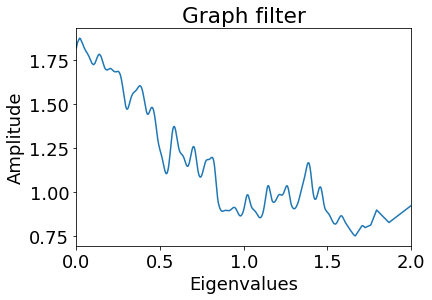

In [40]:
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages('citeseer.pdf')

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

plt.title('Graph filter')
plt.xlabel('Eigenvalues')
plt.ylabel('Amplitude')
plt.xlim([0, 2])
# plt.ylim([0, 3])

plt.plot(e.data.cpu(), new_e[:, 0].data.cpu())

# pdf.savefig(transparent=True, bbox_inches='tight', pad_inches=0)
# plt.close()
# pdf.close()

In [49]:
def condense(matrix, eig, size=10, mode='freq'):
    n = eig.shape[0]
    col_sum = np.zeros((n, size))
    dense = np.zeros((size,size))
    per_freq = np.max(eig) / size
    per_number = n // size
    binning = []
    
    if mode == 'freq':
        axis = [0]
        for i in range(1, size): # 1,2,...,9
            axis.append(np.where(eig > per_freq * i)[0][0])
        axis.append(n-1)
        binning = [axis[i+1]-axis[i] for i in range(size)]
        print('number binning:', binning)
    else:
        axis = [i * per_number for i in range(0, size)]
        axis.append(n-1)
        binning = [eig[axis[i+1]]-eig[axis[i]] for i in range(size)]
        print('frequency binning:', binning)
        axis.append(n-1)
        
    for col in range(size):
        col_sum[:, col] = matrix[:, axis[col]:axis[col+1]].sum(axis=1)
        
    for row in range(size):
        dense[row, :] = col_sum[axis[row]:axis[row+1], :].mean(axis=0)

    return dense, binning

In [50]:
dense, binning = condense(attn.data.cpu().numpy(), e.data.cpu().numpy(), size=9, mode='freq')

number binning: [40, 33, 67, 123, 501, 203, 107, 43, 16]


In [51]:
import cmocean
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [1]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

img = dense

# cmap = ListedColormap(sns.color_palette('Blues'))
cmap = sns.color_palette("light:#5A9", as_cmap=True)

fig, ax = plt.subplots()
im = ax.imshow(img, cmap=cmap)
ax.set_title('Dependence')
ax.axvline(2.5, linestyle='-', c='white', linewidth=2)
ax.axvline(5.5, linestyle='-', c='white', linewidth=2)
ax.axhline(2.5, linestyle='-', c='white', linewidth=2)
ax.axhline(5.5, linestyle='-', c='white', linewidth=2)
# ax.axhline(groundtruth[1], linestyle='-', c='r', linewidth=2)
# ax.set_xlabel("$v_x$")
# ax.set_ylabel("$v_y$")

cbar = fig.colorbar(im)
cbar.locator = ticker.MaxNLocator(nbins=7)  # colorbar上的刻度值个数
cbar.update_ticks()

# cbar.ax.set_yticklabels([''])
# cbar.ax.set_ylabel('Dependence')

labellist = ['', 'Low', '', '', 'Medium', '', '', 'High', '']
ax.set_xticks(ticks = [i for i in range(9)], labels = labellist, rotation = 'horizontal')
ax.set_yticks(ticks = [i for i in range(9)], labels = labellist, rotation = 'horizontal')

# for i in range(9):
#     for j in range(9):
#         text = ax.text(j, i, np.round(dense[i, j], 2), ha="center", va="center", color="black", size=8)

fig.tight_layout()
# fig.savefig('high.pdf', transparent=True, bbox_inches='tight', pad_inches=0)
# plt.close()
plt.show()

NameError: name 'matplotlib' is not defined

In [125]:
fig.savefig('squirrel_dependence.pdf', transparent=True, bbox_inches='tight', pad_inches=0)
plt.close()

In [1]:
import sys
import pickle as pkl
import torch
import math
import dgl
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import pandas as pd
import networkx as nx
import numpy as np
import scipy
import scipy.sparse as sp
import random
import time
from numpy.linalg import eig, eigh

In [2]:
torch.cuda.set_device(2)

def normalize_graph(g):
    g = np.array(g)
    g = g + g.T
    g[g > 0.] = 1.0
    deg = g.sum(axis=1).reshape(-1)
    deg[deg == 0.] = 1.0
    deg = np.diag(deg ** -0.5)
    adj = np.dot(np.dot(deg, g), deg)
    L = np.eye(g.shape[0]) - adj
    return L


def eigen_decompositon(g):
    "The normalized (unit “length”) eigenvectors, "
    "such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i]."
    g = normalize_graph(g)
    e, u = eigh(g)
    return e, u


def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def load_data(dataset_str):
    """
    Loads input data from gcn/data directory
    ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
        object;
    ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.
    All objects above must be saved using python pickle module.
    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("data/{}/ind.{}.{}".format(dataset_str, dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("data/{}/ind.{}.test.index".format(dataset_str, dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    return adj, features, labels


def feature_normalize(x):
    x = np.array(x)
    rowsum = x.sum(axis=1, keepdims=True)
    rowsum = np.clip(rowsum, 1, 1e10)
    return x / rowsum

In [3]:
dataname = 'squirrel'

In [4]:
if dataname in ['chameleon', 'squirrel', 'actor']:
    edge_df = pd.read_csv('./data/{}/'.format(dataname) + 'out1_graph_edges.txt', sep='\t')
    node_df = pd.read_csv('./data/{}/'.format(dataname) + 'out1_node_feature_label.txt', sep='\t')
    feature = node_df[node_df.columns[1]]
    y = node_df[node_df.columns[2]]

    # chameleon 2277
    # squirrel 5201
    # actor 7600

    num_nodes = len(y)
    adj = np.zeros((num_nodes, num_nodes))

    source = list(edge_df[edge_df.columns[0]])
    target = list(edge_df[edge_df.columns[1]])

    for i in range(len(source)):
        adj[source[i], target[i]] = 1.
        adj[target[i], source[i]] = 1.
    
    if dataname == 'actor':
        # for sparse features
        nfeat = 932
        x = np.zeros((len(y), nfeat))

        feature = list(feature)
        feature = [feat.split(',') for feat in feature]
        for ind, feat in enumerate(feature):
            for ff in feat:
                x[ind, int(ff)] = 1.

        x = feature_normalize(x)
    else:
        feature = list(feature)
        feature = [feat.split(',') for feat in feature]
        new_feat = []
        for feat in feature:
            new_feat.append([int(f) for f in feat])
        x = np.array(new_feat)
        x = feature_normalize(x)
    
elif dataname in ['cora', 'citeseer', 'pubmed']:
    adj, x, y = load_data(dataname)
    adj = adj.todense()
    x = x.todense()
    x = feature_normalize(x)
    
else:
    data = np.load('data/amazon_electronics_photo.npz', allow_pickle=True)
    adj = sp.csr_matrix((data['adj_data'], data['adj_indices'], data['adj_indptr']), 
                            shape=data['adj_shape']).toarray()
    feat = sp.csr_matrix((data['attr_data'], data['attr_indices'], data['attr_indptr']), 
                            shape=data['attr_shape']).toarray()
    x = feature_normalize(feat)
    y = data['labels']